# Segunda Aula: From Model to Production 

- Nome: André Goretti
- Matricula: 160112028

Este artigo tem como objetivo melhorar a indentificação de dados para melhor treinar os modelos e subi-lo para um ambiente de produção. Para isso vamos criar um modelo de indentificação de três tipos de maçãs, sendo elas a "Red Delicious", "Royal Gala" e "Pink Lady". <br />
Foi utilizado a plataforma FastAi para a confecção desse modelo

Antes de tudo vamos importar bibliotecas. A nova biblioteca "Gradio" nos da uma interface para rodar nosso modelo treinado onde vamos subilo depois para produção.

In [1]:
from fastbook import *
from fastai.vision.widgets import *
from time import sleep
import gradio as gr

/home/andre/mambaforge/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## 1 - Buscando e Armazenando Imagens

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

Utilizando da biblioteca do DuckDuckGo iremos baixar as imagens.  

Antes de Baixar as imagens foi feito alguns testes para ver se estamos realmente baixando imagens de maçãs e se o DuckDuckGo está respondendo.

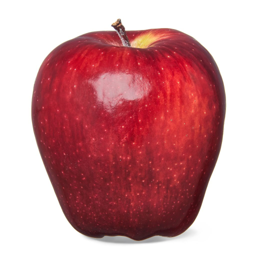

In [3]:
download_url(search_images('red delicious apple', max_images=1)[0], 'red.jpg', show_progress=False)
Image.open('red.jpg').to_thumb(256,256)

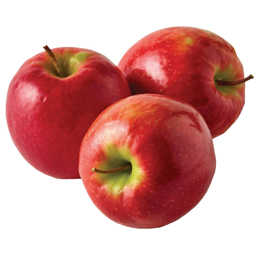

In [4]:
download_url(search_images('pink lady apple', max_images=1)[0], 'pink.jpg', show_progress=False)
Image.open('pink.jpg').to_thumb(256,256)

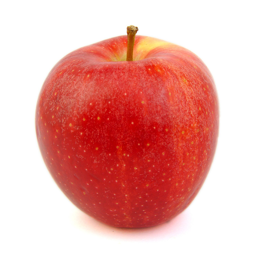

In [5]:
download_url(search_images('royal gala apple', max_images=1)[0], 'royal.jpg', show_progress=False)
Image.open('royal.jpg').to_thumb(256,256)

Agora iremos baixar todas as imagens das maçãs. Foi colocado um limite de 200 imagens por tipo pois existe muitas imagens de maçãs. Depois iremos retirar qualquer imagem quebrada.

In [6]:
apple_types = 'red','pink','royal'
path = Path('apples')
searches = 'red delicious apple', 'pink lady apple', 'royal gala apple'
if not path.exists():
    path.mkdir()
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o}'))
        sleep(10)
        resize_images(path/o, max_size=400, dest=path/o)

In [8]:
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#0) []

Aqui tiveram varias falhas anteriormente, pórem como utilizei o mesmo banco de imagens rodando varias vezes as imagens quebradas foram retiradas da primeira vez, resultando em zero.

In [9]:
failed.map(Path.unlink);

## 2 - Treinando o Modelo
Após a eliminação das imagens quebradas, podemos começar a fazer a categorização das imagens para o treinamento do modelo. Dentre elas serão separadas 20% para validação e o resto para o treinamento. Testei com quantidades diferentes mas o melhor resultado se manteve nos 80/20.

In [7]:
apples = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = apples.dataloaders(path)

Alguns exemplos que a categorização.

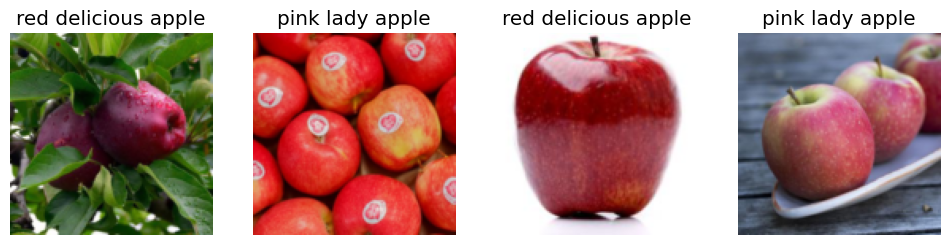

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

   Iremos usar o resnet18 que é um modelo ja treinado e faremos um "fine_tune" para modificar o que o modelo está indentificando.
   

Utilizaremos para o treinamento com o "RandomResizedCrop", que modifica a imagens mudando a posição ou cortando ela aleatoriamente para termos mais variedade de imagens para o modelo. Também foi passado o "aug_transform" padrão. 

In [12]:
apples = apples.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = apples.dataloaders(path)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/home/andre/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/andre/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.457527,0.569904,0.186131,01:34


epoch,train_loss,valid_loss,error_rate,time
0,0.704514,0.360282,0.135036,02:03
1,0.536597,0.196497,0.054745,02:03
2,0.410947,0.160965,0.054745,02:04
3,0.309635,0.113772,0.036496,02:03
4,0.259831,0.107326,0.029197,02:03


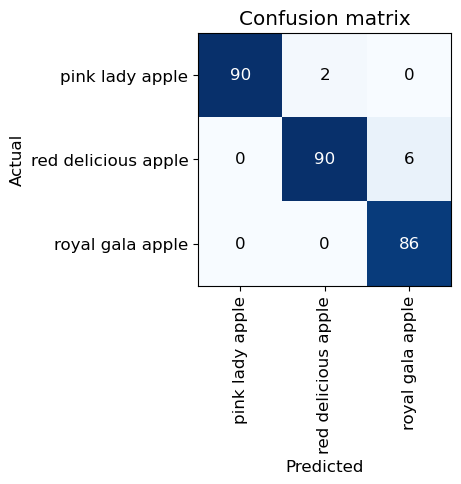

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Após o treinamento podemos notar que a taxa de erro ja está bem baixa perto dos 3%. Para visualizar melhor podemos usar o Confusion matrix que consegue apontar entre quais categorias o modelo teve mais erro, como entre o "Red" e o "Gala" que tem 6 errados.


Para visualizar pontal quais estão dando error podemos plotar os Top Losses, mostrando quais o modelo teve mais dúvida em categorizar.

Outro ponto é que foi utilizado somente a CPU para o Fine Tunning. Tive alguns problemas com path do windows para utilizar a GPU.

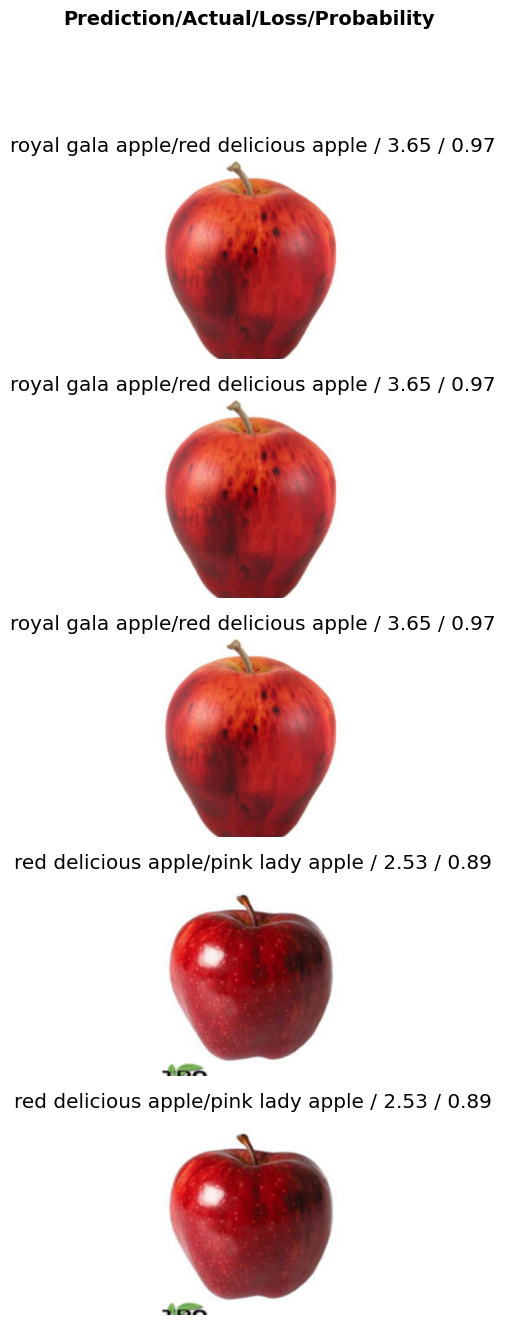

In [15]:
interp.plot_top_losses(5, nrows=5)

Depois de intentificados podemos usar o ImageClassifierCleaner para selecionar e o cleaner.delete para deletar imagens que não condizem com maçãs.<br />
    Também é possivel mudar qual a categoria de cada imagem. Pórem, por eu não conhecer tão bem sobre maçãs, foram somente deletadas as imagens sem maçãs. <br />
    

Após deletar as imagens iremos fazer o Fine Tunning de novo para tentar melhorar os erros.

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [19]:
dls = apples.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.395788,0.602514,0.197080,01:35


epoch,train_loss,valid_loss,error_rate,time
0,0.704834,0.344621,0.124088,02:02
1,0.520373,0.167839,0.058394,02:01
2,0.395441,0.163783,0.047445,02:03
3,0.305349,0.152822,0.032847,02:01
4,0.252349,0.149098,0.025547,02:02


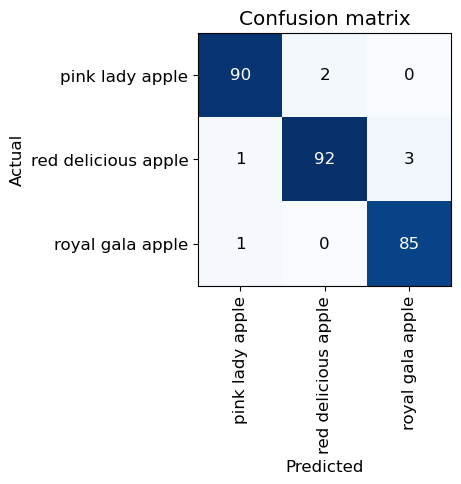

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Podemos ver que melhorou perto de 0,5% a taxa de erro. O valor de melhora foi pequeno pois a taxa antes das seleções ja era muito baixa, então não tinha muito espaço para melhoras. Essas mudanças podem ser vistas nos 3 erros quem eram 6 entre "Red" e "Gala". <br />


Agora estamos prontos para testar e subir o modelo.

## 3 - Testando e fazendo o Deploy do modelo

Primeiramente vamos exportar o modelo no formato .pkl e depois testalo para ver se está fincional. Para isso foram baixados uma imagem de cada tipo de maçã que serão utilizadas depois como exemplos no deploy. 

In [22]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [23]:
learn_inf = load_learner(path/'export.pkl')

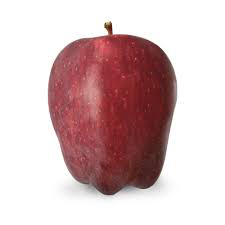

In [29]:
Image.open('maca.jpg').to_thumb(256,256)

In [30]:
learn_inf.predict('maca.jpg')

('red delicious apple',
 TensorBase(1),
 TensorBase([3.7357e-04, 9.7747e-01, 2.2156e-02]))

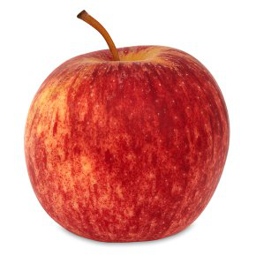

In [31]:
Image.open('maca2.jpg').to_thumb(256,256)

In [32]:
learn_inf.predict('maca2.jpg')


('royal gala apple',
 TensorBase(2),
 TensorBase([1.5334e-06, 5.8248e-05, 9.9994e-01]))

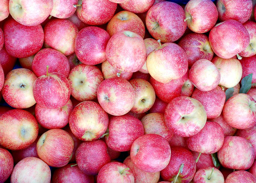

In [33]:
Image.open('maca3.jpg').to_thumb(256,256)

In [34]:
learn_inf.predict('maca3.jpg')

('pink lady apple',
 TensorBase(0),
 TensorBase([9.9966e-01, 2.4812e-05, 3.1253e-04]))

Agora que sabemos que o modelo está funcional vamos esportar ele e criar um arquivo app.py somente com o código nescessário para poder deixar o modelo funcional. Isso é nescessário pois o Hugging Face, onde vamos subir o modelo, segue esse padrão.
Também ulilizaremos a biblioteca Graido para interface como mencionado antes.

In [35]:
learned = load_learner('export.pkl')

In [36]:
categories = ('pink lady apple', 'red delicious apple',  'royal gala apple')
def classify_image(img):
    pred,idx,probs = learned.predict(img)
    return dict(zip(categories, map(float,probs)))

image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = ['maca.jpg', 'maca2.jpg', 'maca3.jpg']
intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)    

/home/andre/mambaforge/lib/python3.10/site-packages/gradio/inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/home/andre/mambaforge/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/home/andre/mambaforge/lib/python3.10/site-packages/gradio/outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/home/andre/mambaforge/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f291f9bcf70>, 'http://127.0.0.1:7860/', None)

![Gradio](1.jpeg)

Link para o Deploy do modelo: https://huggingface.co/spaces/AGoretti/Apple_Types